In [3]:
import seaborn as sns
import addcopyfighandler
import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import LabelEncoder  
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import matplotlib.pyplot as plt

from scipy import integrate, stats

from app import app

from scipy.signal import find_peaks
from scipy.stats import iqr
import TraceFeatures

# Regression models
import statsmodels.stats as sms
import statsmodels.api as sm
from statsmodels.formula.api import ols
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# Save model
import pickle

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
print(os.environ["PATH"])


C:\Users\Santiago\.conda\envs\ox;C:\Users\Santiago\.conda\envs\ox\Library\mingw-w64\bin;C:\Users\Santiago\.conda\envs\ox\Library\usr\bin;C:\Users\Santiago\.conda\envs\ox\Library\bin;C:\Users\Santiago\.conda\envs\ox\Scripts;C:\Users\Santiago\.conda\envs\ox\bin;C:\ProgramData\Anaconda3\condabin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\libnvvp;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0;C:\Windows\System32\OpenSSH;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\Program Files\Git\cmd;C:\Program Files\PuTTY;C:\Program Files\OpenVPN\bin;C:\Program Files (x86)\Eclipse\Sumo\bin;C:\Program Files (x86)\Eclipse\Sumo\tools;C:\Program Files\NVIDIA Corporation\Nsight Compute 2020.3.0;C:\Program Files\nodejs;C:\Program Files\MySQL\MySQL Shell 8.0\bin;C:\Users\Santiago\AppData\Local\Microsoft\WindowsApps;C:\Prog

# Read operation data

In [4]:
print(app.root_path)
new_df = pd.read_csv(app.root_path+'/DataBackup/updated_vehicle_operation.csv')
old_df = pd.read_csv(app.root_path+'/DataBackup/updated_old_vehicle_operation.csv', index_col='id')
new_df.dropna(axis=1, how='all', inplace=True)
old_df.dropna(axis=1, how='all', inplace=True)

C:\Users\Santiago\OneDrive - Universidad EAFIT\Documentos\Universidad\Maestria\Aplicacion\monitoreogrid\app


C:\Users\Santiago\.conda\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (85,88) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\Santiago\.conda\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (83) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


30536

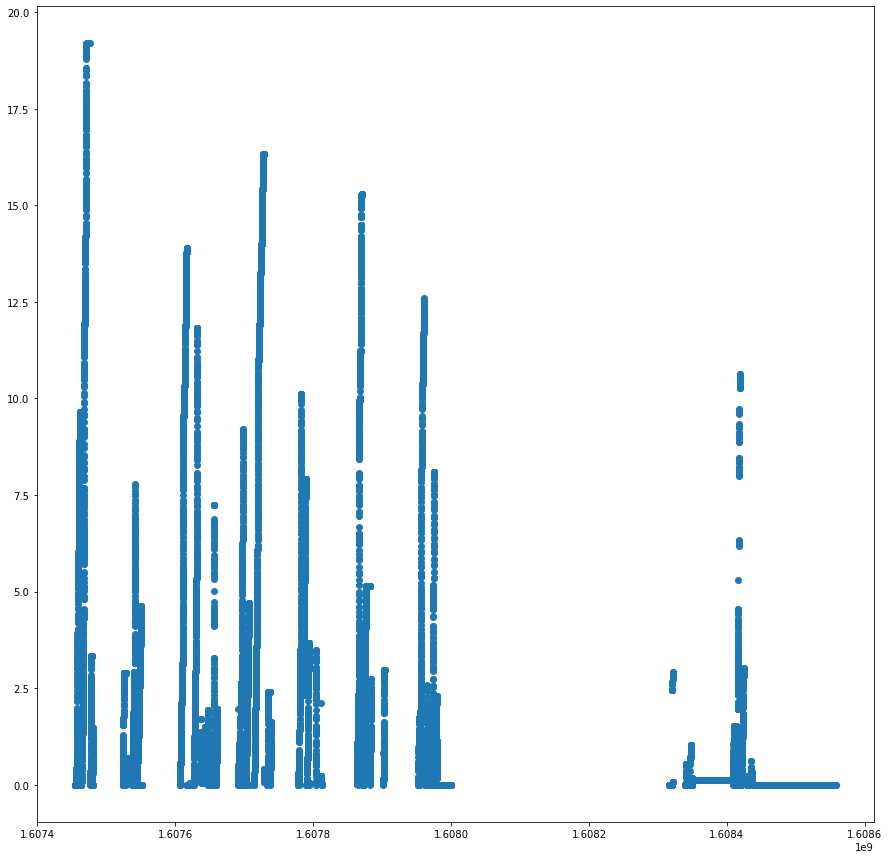

In [5]:
enrgy_n = new_df[new_df['energy'] > -2.51109e+20][['operative_state', 'timestamp2',
       'slope', 'speed', 'odometer', 'user_id',
       'power_kw', 'capacity', 'soc',
       'voltage', 'current', 'consumption',
       'energy', 'rpm',
       'drivemode',
       'mean_acc', 'run',
       'mean_speed']]
plt.figure(figsize=[15,15])
plt.scatter(x=enrgy_n.timestamp2, y=enrgy_n.energy)
len(enrgy_n.energy)


# Validation of run metric

In [6]:

print(old_df['run'][old_df['vehicle_id']=='FSV110'].sum()/1000)
print(old_df['run'][old_df['vehicle_id']=='GHW284'].sum()/1000)
print(new_df['run'][new_df['vehicle_id']=='GHW284'].sum()/1000)


print(old_df['odometer'][old_df['vehicle_id']=='FSV110'].iloc[-1] - old_df['odometer'][old_df['vehicle_id']=='FSV110'].iloc[0])
print(old_df['odometer'][old_df['vehicle_id']=='GHW284'].iloc[-1] - old_df['odometer'][old_df['vehicle_id']=='GHW284'].iloc[0])
print(new_df['odometer'][new_df['vehicle_id']=='GHW284'].iloc[-1] - new_df['odometer'][new_df['vehicle_id']=='GHW284'].iloc[0])


448.7245327608838
226.0294186408727
975.3872763571566
443.0
197.0
938.7399999999998


In [7]:
mixed_operation = old_df.append(new_df, ignore_index=True)
mixed_operation = mixed_operation[mixed_operation.power_kw != 0]

#### Corrigiendo usuarios

In [8]:

mixed_operation.user_id[(mixed_operation.user_id == 'Juan') &
                        (mixed_operation.vehicle_id =='FSV110')] = 'Santiago_Echavarria_FSV110'

mixed_operation.user_id[(mixed_operation.user_id == 'Juan') &
                        (mixed_operation.vehicle_id =='GHW284')] = 'Juan_David_Mira_Alq2'

mixed_operation.user_id[(mixed_operation.user_id == 'Juan_David_Mira') &
                        (mixed_operation.timestamp2 > 1.608e9)] = 'Juan_David_Mira_03'

mixed_operation.user_id[(mixed_operation.user_id == 'Juan_David_Mira')] = 'Juan_David_Mira_01'

mixed_operation.user_id[(mixed_operation.user_id == 'Juan_Mira')] = 'Juan_David_Mira_02'

mixed_operation.user_id.unique()

<ipython-input-8-d625cac47cf9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mixed_operation.user_id[(mixed_operation.user_id == 'Juan') &
<ipython-input-8-d625cac47cf9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mixed_operation.user_id[(mixed_operation.user_id == 'Juan_David_Mira') &
<ipython-input-8-d625cac47cf9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mixed_operation.user_id[(mixed_operation.user_id == 'Juan_David

array(['Santiago_Echavarria_FSV110', 'Juan_David_Mira_Alq2',
       'Ricardo_Mejia', 'Santiago_Echavarria_01', 'Santiago_Echavarria',
       'Jose_Alejandro_Montoya', 'Juan_Gregorio_Arrieta',
       'Juan_David_Mira_01', 'Mauricio_Fernandez', 'Sergio',
       'Jesus_Villa', 'Juan_David_Mira_02', 'Juan_David_Ochoa',
       'David_Rios', 'Ana_Cristina_G', 'Juan_David_Mira_03',
       'Esterban_Betancur'], dtype=object)

#### Corrigiendo los pesos
https://verne.elpais.com/verne/2016/04/19/articulo/1461079768_768006.html 61kg para mujeres y 67kg para hombres

In [9]:
# Para el ZOE y LEAF respectivamente 
mixed_operation.mass[mixed_operation.mass == 170] = 1502
mixed_operation.mass[mixed_operation.mass == 1528] = 1502
mixed_operation.mass[mixed_operation.mass == 1584] = 1549

# Con acompañante mujer
mixed_operation['mass'] = np.where((
    (mixed_operation['user_id'] == 'Juan_David_Ochoa') |
    (mixed_operation['user_id'] == 'Ricardo_Mejia') |
    (mixed_operation['user_id'] == 'Jose_Alejandro_Montoya') |
    (mixed_operation['user_id'] == 'Ana_Cristina_G') | 
    (mixed_operation['user_id'] == 'Esterban_Betancur') | 
    (mixed_operation['user_id'] == 'Juan_Gregorio_Arrieta') |
    (mixed_operation['user_id'] == 'Sergio')),mixed_operation.mass + 61 + 67, mixed_operation.mass)

# Con acompañante hombre
mixed_operation['mass'] = np.where((
    (mixed_operation['user_id'] == 'Juan_David_Mira_01')),
    mixed_operation.mass + 67 + 67, mixed_operation.mass)

# Los que manejaron solos (menos peso)
mixed_operation['mass'] = np.where((
    (mixed_operation['user_id'] == 'Santiago_Echavarria_FSV110') |
    (mixed_operation['user_id'] == 'Santiago_Echavarria_01') |
    (mixed_operation['user_id'] == 'Santiago_Echavarria') |
    (mixed_operation['user_id'] == 'Juan_David_Mira_Alq2') |
    (mixed_operation['user_id'] == 'Juan_David_Mira_02') |
    (mixed_operation['user_id'] == 'Jesus_Villa')),
    mixed_operation.mass + 62, mixed_operation.mass)

# Otros que manejaron solos 
mixed_operation['mass'] = np.where((
    (mixed_operation['user_id'] == 'David_Rios') |
    (mixed_operation['user_id'] == 'Mauricio_Fernandez')),
    mixed_operation.mass + 67, mixed_operation.mass)

mixed_operation.to_csv( app.root_path+'/DataBackup/mixed_operation.csv', index=False)


<ipython-input-9-35f8c6bdecd6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mixed_operation.mass[mixed_operation.mass == 1528] = 1502
<ipython-input-9-35f8c6bdecd6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mixed_operation.mass[mixed_operation.mass == 1584] = 1549


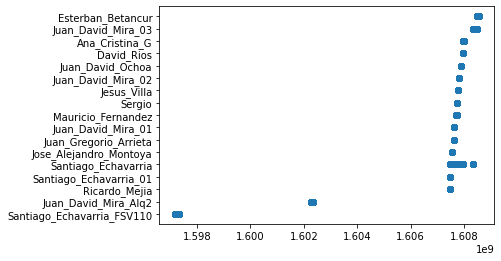

In [10]:
plt.scatter(x=mixed_operation.timestamp2, y=mixed_operation.user_id)

# Segmentation

In [11]:
def gen_trace(df):
    try:
        df.drop(columns='Unnamed: 0', inplace=True)
        df.drop(columns='id', inplace=True)
    except KeyError:
        pass
    trace_id = 1
    aux_trace_id = -1
    trace_array = np.array([])
    suma = 0
    old_name = ''

    for index, row in df.iterrows():
    #for index, row in test.iterrows():
        suma = suma + row['run']
        #row['slope']
        trace_array = np.append(trace_array, aux_trace_id)
        nan = (row['name'] != row['name'])
        
        # Si recorre mas de 300 metros - cambiele el id del segmento actual de aux a definitivo para que se tenga en cuenta
        if suma >=1000:
            trace_array = np.where(trace_array == aux_trace_id, trace_id, trace_array)
            
        # Si cambia de vía - empiece un nuevo tramo se escoge 1200 para ver cambios en consumo
        if suma >=1000 or (old_name != row['name'] and not nan) or row['operative_state'] == 3:  # pendiente
        #if suma >=1100: # or (old_name != row['name'] and not nan):  # pendiente
            suma = 0
            trace_id += 1
            aux_trace_id -= 1

        old_name = row['name']

    print(trace_array)
    try:
        df.drop(["trace_id"], axis=1, inplace=True)
    except KeyError:
        pass
    df.insert(2, "trace_id", trace_array, True)
   
    return df

In [12]:
mixed_operation_trace = gen_trace(mixed_operation)

[-1.000e+00  2.000e+00  2.000e+00 ... -5.865e+03 -5.865e+03 -5.865e+03]


# Relacion entre pedal de aceleración y potencia


Corr with power =  0.7611497846073747
P value =  9.73013158955793e-144
Corr with current =  0.34712148500577955
P value =  8.411064548088247e-23
Corr with acc =  0.002444903101466814
P value =  0.9465275387034696
len =  755


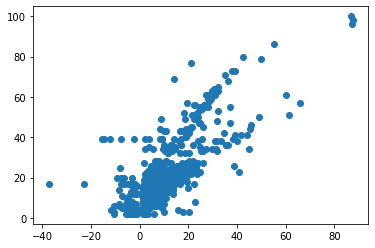

In [13]:
FRV020 = mixed_operation_trace[
    (mixed_operation_trace['vehicle_id'] == 'FRV020') &
    ((mixed_operation_trace['power_kw'] < -1) | (mixed_operation_trace['power_kw'] > 1)) &
    (mixed_operation_trace['throttle'] > 1) &
    ((mixed_operation_trace['throttle'] < 29) | (mixed_operation_trace['throttle'] > 31))]
FRV020_esteban = FRV020[FRV020['user_id'] == 'Esteban_Betancur']
plt.figure()
plt.scatter(x=FRV020['power_kw'], y=FRV020['throttle'])

#Correlacion
corr_coef, p_value = stats.pearsonr(FRV020['power_kw'].to_numpy(), FRV020['throttle'])
print('Corr with power = ',corr_coef)
print('P value = ',p_value)

corr_coef_curr, p_value_curr = stats.pearsonr(FRV020['current'].to_numpy(), FRV020['throttle'])
print('Corr with current = ',corr_coef_curr)
print('P value = ',p_value_curr)

corr_coef_acc, p_value_acc = stats.pearsonr(FRV020['mean_acc'].to_numpy(), FRV020['throttle'])
print('Corr with acc = ',corr_coef_acc)
print('P value = ',p_value_acc)
print('len = ',len(FRV020))

In [14]:
classifier_df = mixed_operation_trace[mixed_operation_trace['trace_id'] > 0]
print(len(classifier_df))

traces = classifier_df.groupby(['trace_id'])
len(traces)

12225


954

In [15]:

def peak_features(trace, var, limit_u, limit_l, name):
    peaks, peak_values = find_peaks(var, height=limit_u)  # mas de nedio acelerador
    valleys, valleys_values = find_peaks(-var, height=limit_l)
    num_peaks_minuto = 60 * len(peaks) / (trace['timestamp2'].iloc[-1] - trace['timestamp2'].iloc[0])
    num_valleys_minuto = 60 * len(valleys) / (trace['timestamp2'].iloc[-1] - trace['timestamp2'].iloc[0])

    prom_sobrepaso_peak = np.mean(peak_values['peak_heights']) / limit_u
    if np.isnan(prom_sobrepaso_peak):
        prom_sobrepaso_peak = 1

    # Promedio de sobrepaso de la referencia máxima de frenado
    prom_sobrepaso_valley = np.mean(valleys_values['peak_heights']) / limit_l
    if np.isnan(prom_sobrepaso_valley):
        prom_sobrepaso_valley = 1

    # Promedio de valor absoluto de la aceleración
    prom_abs = np.mean(np.absolute(var))
    std = np.std(var)
    max_val = np.max(var)
    return num_peaks_minuto, num_valleys_minuto, prom_sobrepaso_peak, prom_sobrepaso_valley, prom_abs, std, max_val


def feature_extraction(trace):
    trace['cumulative_distance'] = trace['run'].cumsum()

    # Picos aceleraciones y frenadas
    acc = trace['mean_acc'].to_numpy()
    num_acc_min, num_acc_fr_min, prom_sobrepaso_acc, prom_sobrepaso_fren, prom_abs_acc, std_acc, max_acc = peak_features(
        trace, acc, 1, 1, ',mean_acc')  # mas de nedio acelerador

    # Derivative of da/dt to find Jerk  - partir en otra función
    time_indexed_acc = pd.Series(acc, index=trace['timestamp2'])
    jerk = time_indexed_acc.diff().to_numpy()
    num_jerk_acc_min, num_jerk_freno_min, prom_sobrepaso_jerk_acc, prom_sobrepaso_jerk_freno, prom_abs_jerk, std_jerk, max_jerk = peak_features(
        trace, jerk[1:], 1.5, 1.5, 'jerk')  # mas de nedio acelerador

    # Picos corriente
    current = trace['current'].to_numpy()
    num_current_min, num_current_fr_min, prom_sobrepaso_current, prom_sobrepaso_current_fr, prom_abs_current, std_current, max_current = peak_features(
        trace, current, 60, 100, 'current')  # mas de nedio acelerador

    slope = np.mean(trace['slope'])

    power_nominal_zoe = 65.6216
    power_nominal_leaf = 81.2813
    if trace['vehicle_id'].iloc[0] == 'FRV020':
        power_nominal = power_nominal_leaf
    else:
        power_nominal = power_nominal_zoe
        
    mass = trace['mass'].iloc[0]

#     std_power = np.std(trace['power_kw']) / power_nominal
#     iqr_power = iqr(trace['power_kw']) / power_nominal
#     prom_abs_power = np.mean(np.absolute(trace['power_kw'])) / power_nominal
#     max_power = np.max(trace['power_kw']) / power_nominal
#     min_power = np.min(trace['power_kw']) / power_nominal

    # Medidas de potencia específica
    std_power = np.std(trace['power_kw']) / 1
    iqr_power = iqr(trace['power_kw']) / 1
    prom_abs_power = np.mean(np.absolute(trace['power_kw'])) / 1
    max_power = np.max(trace['power_kw']) / 1
    min_power = np.min(trace['power_kw']) / 1


    # With trip energy used
    consumption1 = trace['energy'].iloc[-1] - trace['energy'].iloc[0]

    # With battery capacity
    consumption2 = trace['capacity'].iloc[0] - trace['capacity'].iloc[-1]

    # With power integration
    consumption3 = integrate.cumtrapz(trace['power_kw'], trace['timestamp2'])
    consumption3 = (consumption3[-1] - consumption3[0]) / 3600

    if slope < 0:
        consumption1 = consumption3

    # Average specific consumption kWh / kg
    consumption = (0.23* consumption1 + 0.3*consumption2 + 0.47*consumption3) / 1
    kms = trace['cumulative_distance'].iloc[-1] / 1000
    
    # kWh / kg*km  --> Energy per km per kg
    consumption_per_km = consumption / kms
    std_current_std_jerk = std_current * std_jerk
    max_speed = np.max(trace['speed'])
    mean_speed = np.mean(trace['speed'])
    median_speed = np.median(trace['speed'])
    std_speed = np.std(trace['speed'])
    time = trace['timestamp2'].iloc[-1] - trace['timestamp2'].iloc[0]

    # This indicator detects traffic (including red lights)
    stopped_time = 0
    old_time = trace['timestamp2'].iloc[0]
    prev = False
    for index, row in trace[['timestamp2', 'mean_speed']].iterrows():
        if row['mean_speed'] < 2:
            if prev:
                stopped_time += row['timestamp2'] - old_time

            old_time = row['timestamp2']
            prev = True
        else:
            prev = False
    idle_time = stopped_time / time
    traffic_factor = mean_speed / std_speed

    mean_temp = trace['ext_temp'].mean()
    nominal_speed = trace['speed_kph'].iloc[0]

    speed_ind = nominal_speed / np.max(trace['speed'])
    try:
        test_id = trace['test_id'].iloc[0]
    except KeyError:
        test_id = 0

    # porcentaje de primary, de secondary

    return [num_acc_min, num_acc_fr_min, prom_sobrepaso_acc, prom_sobrepaso_fren, prom_abs_acc, std_acc,
            num_jerk_acc_min, num_jerk_freno_min, prom_sobrepaso_jerk_acc,
            prom_sobrepaso_jerk_freno, prom_abs_jerk, std_jerk, std_power, prom_abs_power, consumption,
            kms, consumption_per_km, num_current_min, num_current_fr_min, prom_sobrepaso_current,
            prom_sobrepaso_current_fr, prom_abs_current, std_current, std_current_std_jerk,
            trace['highway'].iloc[0], slope, nominal_speed, max_current, max_jerk, max_acc,
            max_power, min_power, max_speed, mean_speed, std_speed, iqr_power, trace['soc'].mean(),
            mean_temp, time, idle_time,
            traffic_factor, trace['user_id'].iloc[0], trace['vehicle_id'].iloc[0], speed_ind, test_id,
            trace['timestamp'].iloc[-1],  trace['mass'].iloc[-1]]


def generate_features_df(lst):
    cols = ['num_acc_min', 'num_acc_fr_min', 'prom_sobrepaso_acc', 'prom_sobrepaso_fren', 'prom_abs_acc',
            'std_acc', 'num_jerk_acc_min', 'num_jerk_freno_min', 'prom_sobrepaso_jerk_acc',
            'prom_sobrepaso_jerk_freno', 'prom_abs_jerk', 'std_jerk', 'std_power', 'prom_abs_power',
            'consumption', 'kms', 'consumption_per_km', 'num_current_min', 'num_current_fr_min',
            'prom_sobrepaso_current', 'prom_sobrepaso_current_fr', 'prom_abs_current', 'std_current',
            'std_current_std_jerk', 'highway', 'slope', 'nominal_speed', 'max_current', 'max_jerk', 'max_acc',
            'max_power', 'min_power', 'max_speed', 'mean_speed', 'std_speed', 'iqr_power', 'mean_soc', 'mean_temp', 'travel_time',
            'idle_time', 'traffic_factor', 'user_id', 'vehicle_id', 'speed_ind', 'test_id', 'end_time', 'mass']

    return pd.DataFrame(lst, columns=cols)



In [16]:
lst = []
for index, trace in traces:
    if index > 0 and len(trace) > 1:
        lst.append(feature_extraction(trace))

features = generate_features_df(lst)

C:\Users\Santiago\.conda\envs\ox\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Santiago\.conda\envs\ox\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-15-e5b5d197d253>:107: RuntimeWarning: invalid value encountered in double_scalars
  traffic_factor = mean_speed / std_speed
<ipython-input-15-e5b5d197d253>:112: RuntimeWarning: divide by zero encountered in double_scalars
  speed_ind = nominal_speed / np.max(trace['speed'])


count    647.000000
mean      78.547141
std       46.876729
min        6.000000
25%       52.000000
50%       65.000000
75%       92.000000
max      299.000000
Name: travel_time, dtype: float64

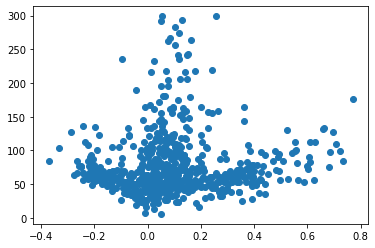

In [19]:
plt.scatter(x=features.consumption, y=features.travel_time)
features.travel_time.describe()

In [17]:
bc = features.copy()
#features=bc.copy()
features.mean_temp.fillna(value=np.mean(features.mean_temp), inplace=True)

In [18]:
from sklearn.preprocessing import LabelEncoder  
features = features[features['kms'] <= 1.1]
features = features[(features['max_current'] < 250) ]
features = features[(features['travel_time'] < 300) ]

#features = features[(features['traffic_factor'] < 45) ]

# Cuando es cono 1200 mts
features = features[(features['consumption'] > -0.5) & (features['consumption'] < 1)]

# Cuando es con 300mts
#features = features[(features['consumption'] > -0.15) & (features['consumption'] < 0.4)]

#features = features[(features['consumption_per_km'] < 0.8) ]

features = features[features['std_acc'] != 0]

# Se eliminan los datos que tengan error de medición en la potencia
features = features[features['max_power'] != 0]

#features = features[features['vehicle_id'] != 'FRV020']

print(len(features))
features = features[(features['consumption_per_km'] > -4) | (features['consumption_per_km'] < 1) ].dropna()
print(len(features))

le = LabelEncoder()
features['highway_enc'] = le.fit_transform(features['highway'])
features['slope_cat'] = pd.cut(features["slope"], np.arange(-10,10.1,4) )
features['slope_cat'] = features['slope_cat'].astype('string')

print('equal to 0 =',len(features[features['consumption'] == 0]))
print('different from 0 =', len(features[features['consumption'] != 0]))

features.corr()['consumption'].sort_values()

647
647
equal to 0 = 0
different from 0 = 647


traffic_factor              -0.172468
nominal_speed               -0.073500
mean_soc                    -0.064514
speed_ind                   -0.063763
highway_enc                 -0.048417
mean_speed                  -0.039903
prom_sobrepaso_current_fr   -0.032633
num_current_fr_min          -0.022360
prom_sobrepaso_acc          -0.011469
kms                          0.001843
idle_time                    0.018291
mass                         0.018562
num_acc_min                  0.018580
prom_sobrepaso_jerk_freno    0.043175
max_speed                    0.049980
num_jerk_acc_min             0.055938
prom_sobrepaso_jerk_acc      0.073669
travel_time                  0.075100
max_acc                      0.088807
prom_sobrepaso_fren          0.089171
num_jerk_freno_min           0.089538
std_speed                    0.123392
mean_temp                    0.133286
num_acc_fr_min               0.146657
std_jerk                     0.193237
max_jerk                     0.194185
std_acc     

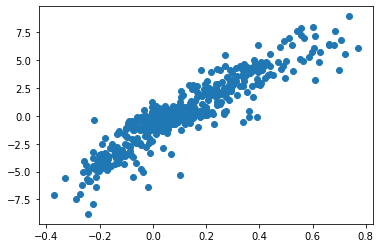

In [20]:
plt.scatter(x=features.consumption, y=features.slope)

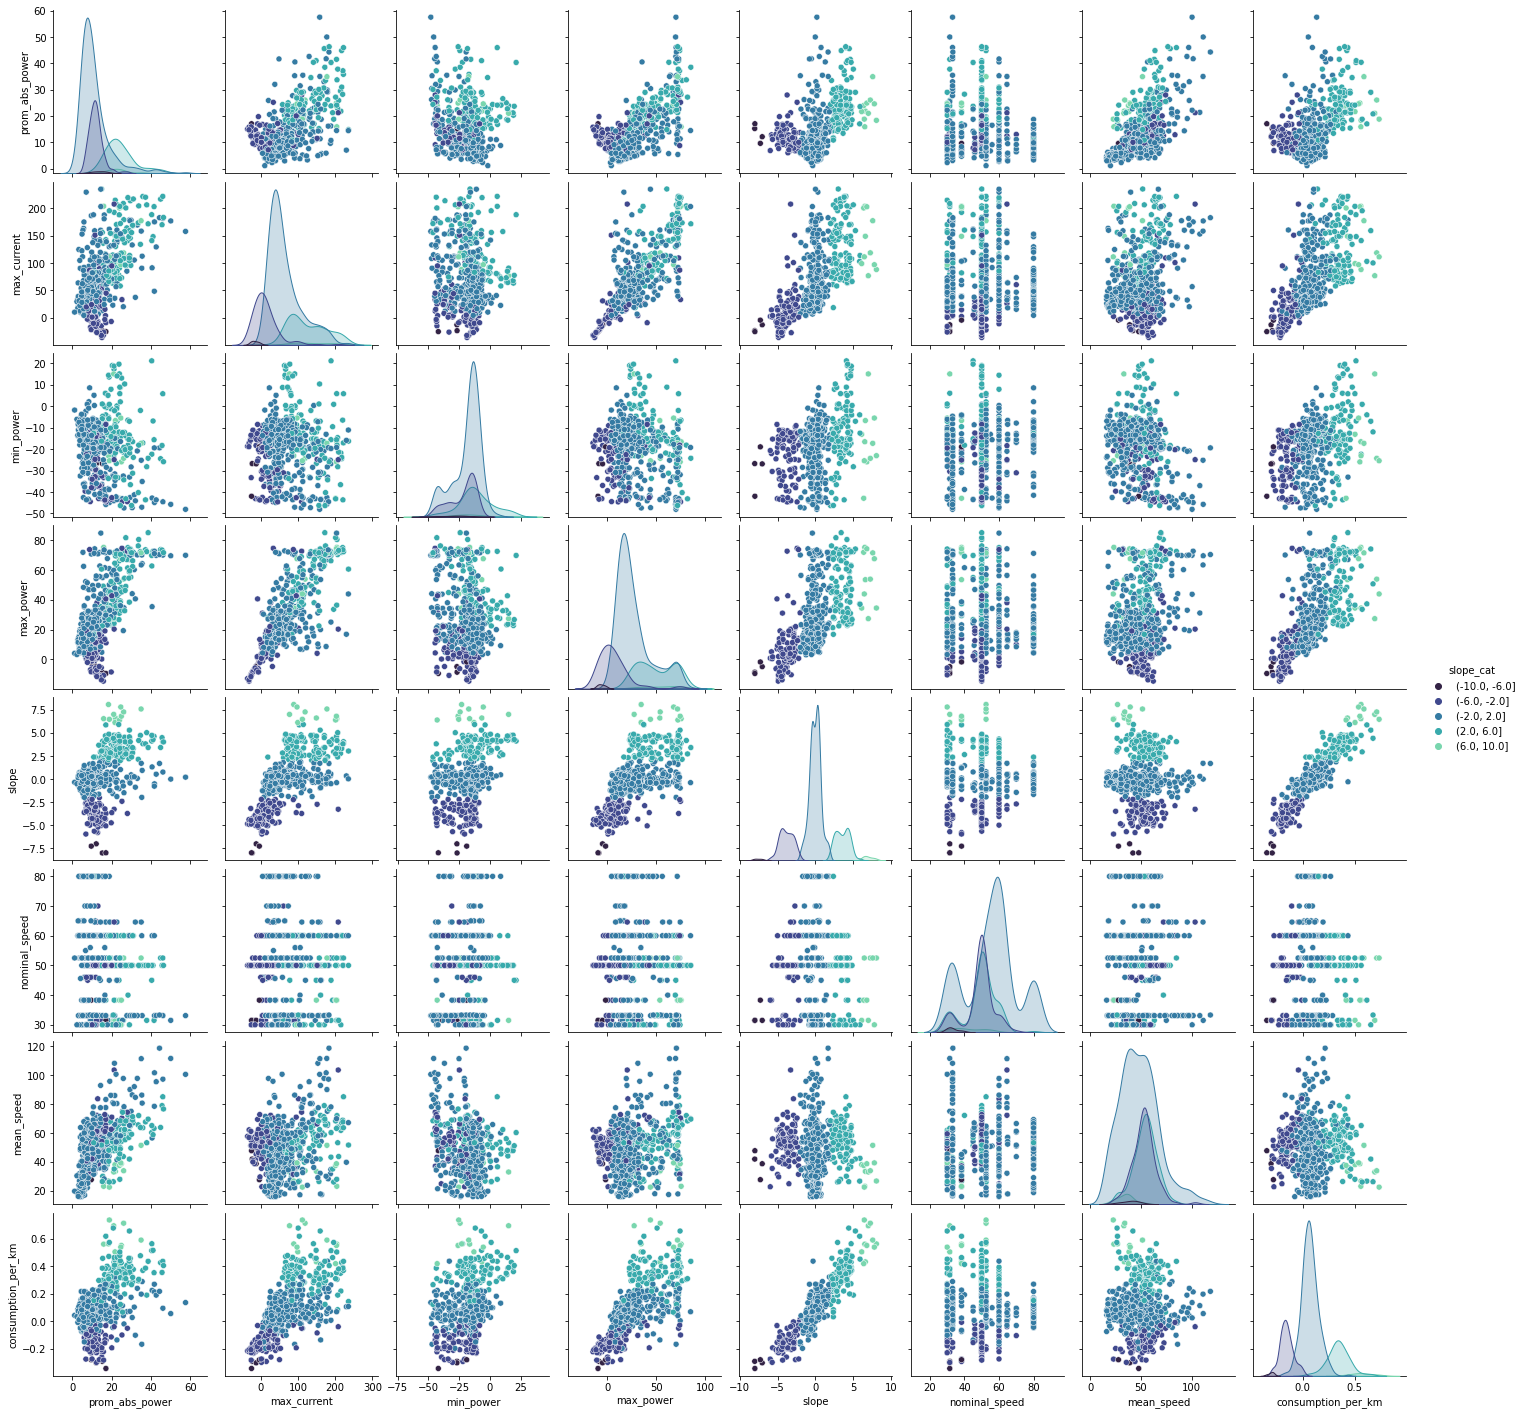

In [1218]:
sns.pairplot(features.dropna(), hue='slope_cat', palette='mako', vars=['prom_abs_power', 'max_current', 'min_power', 'max_power', 'slope', 'nominal_speed', 'mean_speed',
                                             'consumption_per_km'], kind= 'scatter')

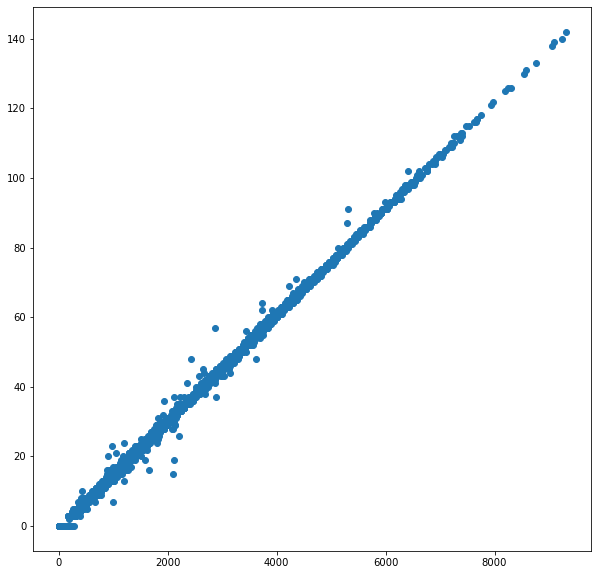

In [1196]:
rpm = new_df[new_df.rpm > 0]
plt.scatter(x=rpm.rpm, y=rpm.speed)


# To implement - pace during route
### TellsF the user if his current rate is lower or upper to the estimated

C:\Users\Santiago\.conda\envs\ox\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


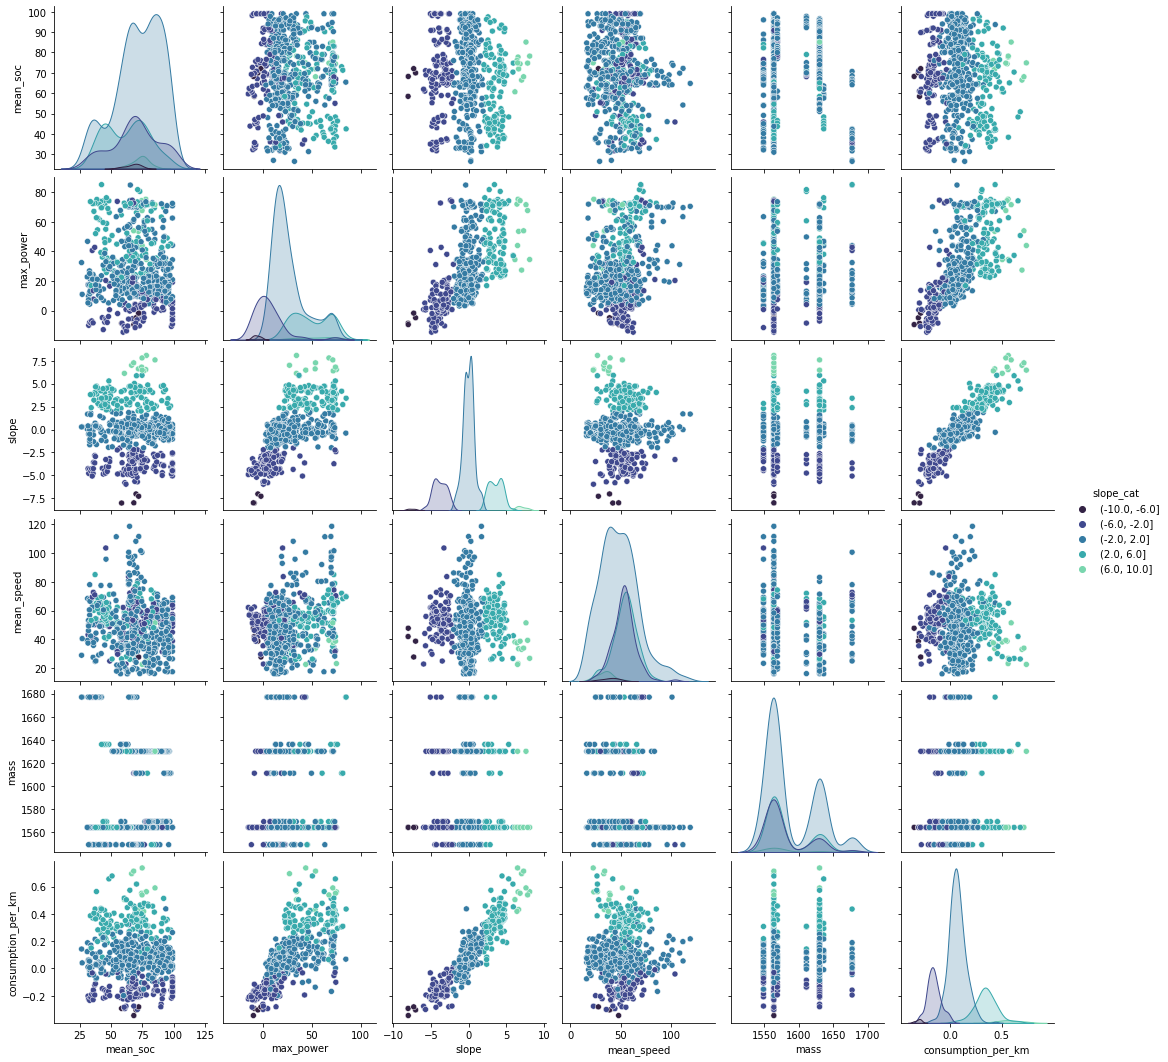

In [1219]:
sns.pairplot(features.dropna(), hue='slope_cat', palette='mako', vars=['mean_soc', 'max_power', 'slope', 'mean_speed', 'mass',
                                             'consumption_per_km'], kind='scatter')


In [1220]:
features.user_id.unique()

array(['Santiago_Echavarria_FSV110', 'Juan_David_Mira_Alq2',
       'Ricardo_Mejia', 'Santiago_Echavarria_01', 'Santiago_Echavarria',
       'Jose_Alejandro_Montoya', 'Juan_Gregorio_Arrieta',
       'Juan_David_Mira_01', 'Mauricio_Fernandez', 'Sergio',
       'Jesus_Villa', 'Juan_David_Mira_02', 'Juan_David_Ochoa',
       'David_Rios', 'Ana_Cristina_G', 'Juan_David_Mira_03',
       'Esterban_Betancur'], dtype=object)

['Santiago_Echavarria_FSV110' 'Juan_David_Mira_Alq2' 'Ricardo_Mejia'
 'Santiago_Echavarria_01' 'Santiago_Echavarria' 'Jose_Alejandro_Montoya'
 'Juan_Gregorio_Arrieta' 'Juan_David_Mira_01' 'Mauricio_Fernandez'
 'Sergio' 'Jesus_Villa' 'Juan_David_Mira_02' 'Juan_David_Ochoa'
 'David_Rios' 'Ana_Cristina_G' 'Juan_David_Mira_03' 'Esterban_Betancur']


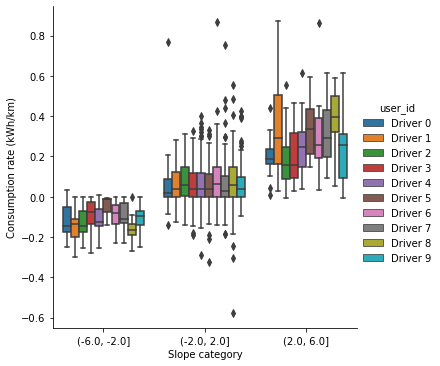

In [1197]:
x=features[(features['slope'] > -6) & (features['slope'] < 6)]
print(x.user_id.unique())
x = x[x['user_id'] != 'Juan_David_Mira_01']
x = x[x['user_id'] != 'Santiago_Echavarria_FSV110']

x = x[x['user_id'] != 'Santiago_Echavarria']
x = x[x['user_id'] != 'Santiago_Echavarria_01']  # Por ser muy atipico
x = x[x['user_id'] != 'Juan_David_Mira_01']
x = x[x['user_id'] != 'Juan_David_Mira_02']
x = x[x['user_id'] != 'Juan_David_Mira_03']
x = x[x['user_id'] != 'Juan_David_Mira_Alq2']

x.loc[x['user_id'] == 'Ricardo_Mejia', 'user_id'] = 'Driver 0'
x.loc[x['user_id'] == 'Jose_Alejandro_Montoya', 'user_id'] = 'Driver 1'
x.loc[x['user_id'] == 'Juan_Gregorio_Arrieta', 'user_id'] = 'Driver 2'
x.loc[x['user_id'] == 'Mauricio_Fernandez', 'user_id'] = 'Driver 3'
x.loc[x['user_id'] == 'Sergio', 'user_id'] = 'Driver 4'
x.loc[x['user_id'] == 'Jesus_Villa', 'user_id'] = 'Driver 5'
x.loc[x['user_id'] == 'Juan_David_Ochoa', 'user_id'] = 'Driver 6'
x.loc[x['user_id'] == 'David_Rios', 'user_id'] = 'Driver 7'
x.loc[x['user_id'] == 'Ana_Cristina_G', 'user_id'] = 'Driver 8'
x.loc[x['user_id'] == 'Esterban_Betancur', 'user_id'] = 'Driver 9'


x.slope_cat = x.slope_cat.astype(str)
x.rename(columns={"max_power": "MBPO (kW)","mean_speed": "Nominal speed (km/h)",
                                       'consumption_per_km': 'Consumption rate (kWh/km)','slope_cat':'Slope category'}, inplace=True)


sns.catplot(x='Slope category', y='Consumption rate (kWh/km)', hue='user_id', data=x.sort_values(by=['user_id', 'slope' ]), kind='box')

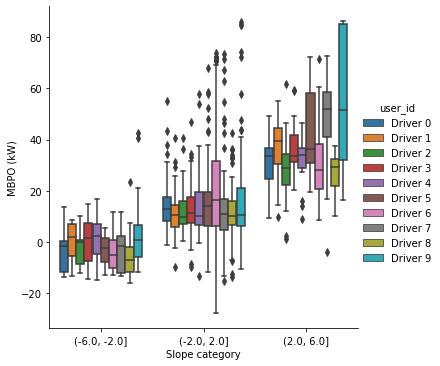

In [1198]:
sns.catplot(x='Slope category', y='MBPO (kW)', hue='user_id', data=x.sort_values(by=['user_id', 'slope' ]), kind='box')

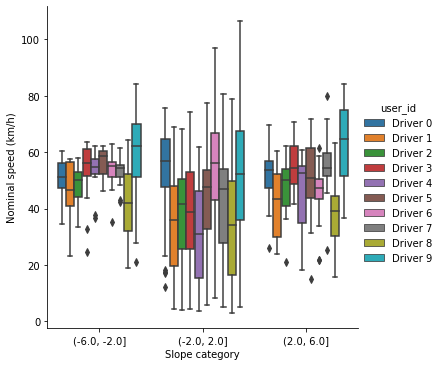

In [1199]:
sns.catplot(x='Slope category', y='Nominal speed (km/h)', hue='user_id', data=x.sort_values(by=['user_id', 'slope' ]), kind='box')

In [1201]:
from   scipy import stats

x1=x[(x['slope'] > 2) ]
x2=x[(x['slope'] > -2) & (x['slope'] <= 2)]

stat, p, med, tbl = stats.median_test(x1['Consumption rate (kWh/km)'][(x1['user_id'] == 'Driver 8')],
                                      x1['Consumption rate (kWh/km)'][(x1['user_id'] == 'Driver 3')])
print('p = ' + str(p), '\n')

# Different slope group
t2, p2 = stats.ttest_ind(x1['Consumption rate (kWh/km)'][(x1['user_id'] == 'Driver 8')] ,
                         x2['Consumption rate (kWh/km)'][x2['user_id'] == 'Driver 8' ])
print('For same user - different slope group')
print('t = ' + str(t2))
print('p = ' + str(p2), '\n')

# Same slope group > 1.7
t2, p2 = stats.ttest_ind(x1['Consumption rate (kWh/km)'][(x1['user_id'] == 'Driver 3')] ,
                         x1['Consumption rate (kWh/km)'][x1['user_id'] == 'Driver 7' ])
print('For 2 different users - slope group > 2')
print('t = ' + str(t2))
print('p = ' + str(p2), '\n')

# Same slope group > 1.7
t2, p2 = stats.ttest_ind(x1['Nominal speed (km/h)'][(x1['user_id'] == 'Driver 3')] ,
                         x1['Nominal speed (km/h)'][x1['user_id'] == 'Driver 7' ])
print('Nominal speed (km/h) For 2 different users - slope group > 2')
print('t = ' + str(t2))
print('p = ' + str(p2), '\n')

# Same slope group > 1.7
t2, p2 = stats.ttest_ind(x1['MBPO (kW)'][(x1['user_id'] == 'Driver 3')] ,
                         x1['MBPO (kW)'][x1['user_id'] == 'Driver 7' ])
print('MBPO (kW) For 2 different users - slope group > 2')
print('t = ' + str(t2))
print('p = ' + str(p2), '\n')

p = 0.0034870048921413857 

For same user - different slope group
t = 7.308564482476684
p = 4.9272801513014537e-11 

For 2 different users - slope group > 2
t = -2.1711717517761455
p = 0.038242859821446006 

Nominal speed (km/h) For 2 different users - slope group > 2
t = 0.058252425127717916
p = 0.9539471114876215 

MBPO (kW) For 2 different users - slope group > 2
t = -1.5745498442282535
p = 0.1262082072133301 



# Separate 25 km for measuring and rest for test (for the test cases)


In [21]:
features['cumdist1'] = features[(features['user_id'] == 'Santiago_Echavarria') ].kms.cumsum()  #features['cumdist'] 
features.loc[features['cumdist1'] > 25, 'user_id'] = 'Santiago_Echavarria_test'
features.loc[features['cumdist1'] < 25, 'user_id'] = 'Santiago_Echavarria_measure'

### Se utiliza para train los datos de las pruebas contraladas de todos los usuariois

In [22]:
train = features[(features['user_id'] != 'Santiago_Echavarria_test') &
                 (features['user_id'] != 'Santiago_Echavarria_measure')]
test = features.loc[features.index.difference(train.index)]

In [23]:
train.user_id.unique()

array(['Santiago_Echavarria_FSV110', 'Juan_David_Mira_Alq2',
       'Ricardo_Mejia', 'Santiago_Echavarria_01',
       'Jose_Alejandro_Montoya', 'Juan_Gregorio_Arrieta',
       'Juan_David_Mira_01', 'Mauricio_Fernandez', 'Sergio',
       'Jesus_Villa', 'Juan_David_Mira_02', 'Juan_David_Ochoa',
       'David_Rios', 'Ana_Cristina_G', 'Juan_David_Mira_03',
       'Esterban_Betancur'], dtype=object)

# Slope groups

In [24]:
slope_groups = train.groupby(by=["slope_cat"])
mean_features_by_slope = slope_groups[['max_power', 'min_power', 'consumption_per_km']].mean().reset_index()
mean_features_by_slope.rename(columns={"max_power": "mean_max_power","min_power": "mean_min_power",
                                       'consumption_per_km': 'mean_consumption_per_km','slope':'slope_cat'}, inplace=True)

mean_features_by_slope.to_csv('mean_features_by_slope.csv', index=False)


#Se lee la que se saco con segmentos de 300m.
mean_features_by_slope = pd.read_csv('mean_features_by_slope.csv')
mean_features_by_slope['slope_cat'] = mean_features_by_slope['slope_cat'].astype('string')


train_cons = pd.merge(left=train, right=mean_features_by_slope,
                      left_on='slope_cat', right_on='slope_cat')

train_cons['user_id'].unique()

array(['Santiago_Echavarria_FSV110', 'Juan_David_Mira_Alq2',
       'Ricardo_Mejia', 'Santiago_Echavarria_01',
       'Jose_Alejandro_Montoya', 'Juan_Gregorio_Arrieta',
       'Juan_David_Mira_01', 'Mauricio_Fernandez', 'Sergio',
       'Jesus_Villa', 'Juan_David_Ochoa', 'David_Rios', 'Ana_Cristina_G',
       'Juan_David_Mira_03', 'Esterban_Betancur', 'Juan_David_Mira_02'],
      dtype=object)

# User and slope groups

In [25]:
slope_user_groups = train.groupby(by=['slope_cat', 'user_id'])
mean_features_by_user_and_slope = slope_user_groups[['max_power', 'min_power', 'consumption_per_km']].mean().reset_index()
mean_features_by_user_and_slope.rename(columns={"max_power": "mean_max_power_usr",
                    "min_power": "mean_min_power_usr", 'consumption_per_km': 'mean_consumption_per_km_usr'}, inplace=True)

mean_features_by_user_and_slope.to_csv('mean_features_by_user_and_slope.csv', index=False)


#Se lee la que se saco con segmentos de 300m.
mean_features_by_user_and_slope = pd.read_csv('mean_features_by_user_and_slope.csv')
mean_features_by_user_and_slope['slope_cat'] = mean_features_by_user_and_slope['slope_cat'].astype('string')

train_cons = pd.merge(left=train_cons, right=mean_features_by_user_and_slope,
                              left_on=['user_id', 'slope_cat'], right_on=['user_id', 'slope_cat'])

# Esta tabla se sacó con segmentos de 300m
mean_features_by_user_and_slope.head(60)

,slope_cat,user_id,mean_max_power_usr,mean_min_power_usr,mean_consumption_per_km_usr
0,"(-10.0, -6.0]",Ricardo_Mejia,0.872000,-28.529000,-0.234375
1,"(-10.0, -6.0]",Santiago_Echavarria_FSV110,1.065800,-27.385200,-0.240119
2,"(-10.0, -6.0]",Sergio,8.269000,-15.283000,-0.225719
3,"(-2.0, 2.0]",Ana_Cristina_G,18.355750,-10.272500,0.100723
4,"(-2.0, 2.0]",David_Rios,20.881154,-18.304385,0.091880
5,"(-2.0, 2.0]",Esterban_Betancur,25.840474,-14.794961,0.075740
6,"(-2.0, 2.0]",Jesus_Villa,23.387176,-16.925294,0.066965
7,"(-2.0, 2.0]",Jose_Alejandro_Montoya,16.026875,-12.016625,0.056745
8,"(-2.0, 2.0]",Juan_David_Mira_01,30.576182,-17.618364,0.099697
9,"(-2.0, 2.0]",Juan_David_Mira_02,44.799500,-36.224500,0.168803


In [133]:
model_ft = train_cons[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']]
selected_ft = train_cons[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope', 'consumption_per_km']]
print(len(selected_ft))
selected_ft.corr()

582


,mean_max_power_usr,mean_soc,mean_speed,slope,consumption_per_km
mean_max_power_usr,1.000000,-0.147432,0.116725,0.773627,0.750553
mean_soc,-0.147432,1.000000,-0.149612,-0.053297,-0.052451
mean_speed,0.116725,-0.149612,1.000000,-0.036802,-0.036143
slope,0.773627,-0.053297,-0.036802,1.000000,0.922854
consumption_per_km,0.750553,-0.052451,-0.036143,0.922854,1.000000


# Scaling

In [134]:
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

# For other sklearn models differente than linear regression
scaler = MinMaxScaler()
scaler.fit(train_cons[selected_ft.columns])

# For linear regression
scaler_lm = MinMaxScaler()
scaler_lm.fit(train_cons[model_ft.columns])

train_scaled = pd.DataFrame(scaler.transform(train_cons[selected_ft.columns]), columns=selected_ft.columns)

train_lm_scaled = pd.DataFrame(scaler_lm.transform(train_cons[model_ft.columns]), columns=model_ft.columns)
train_lm_scaled['consumption_per_km'] = train_scaled['consumption_per_km']

# Linear Model

In [135]:
formula = 'consumption_per_km ~ slope + mean_max_power_usr + mean_soc + mean_speed -1 ' # 0.84

lm_consumo = ols(formula = formula, data = train_lm_scaled).fit()
print(lm_consumo.summary())

                                 OLS Regression Results                                
Dep. Variable:     consumption_per_km   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              6073.
Date:                Sun, 28 Feb 2021   Prob (F-statistic):                        0.00
Time:                        21:34:37   Log-Likelihood:                          731.64
No. Observations:                 582   AIC:                                     -1455.
Df Residuals:                     578   BIC:                                     -1438.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

<Figure size 1440x1440 with 0 Axes>

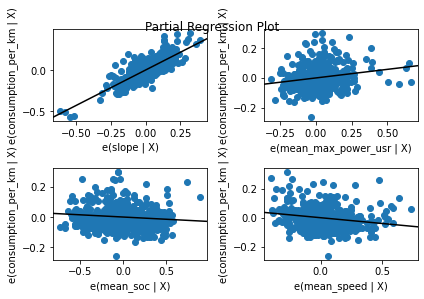

In [136]:
plt.figure(figsize =[20,20])
fig=sm.graphics.plot_partregress_grid(lm_consumo)


# Test case 2:

Aqui dividimos el set de validación en 2 partes: Santiago_Echavarria_measure y Santiago_Echavarria_test.
Santiago_Echavarria_measure contiene 25 km de manejo y se utilizará para determinar los promedios de las conductas de usuario. El conjunto Santiago_Echavarria_test contiene los siguientes kilómetros y será el conjunto donde se aplicará el algoritmo basado en los promedios calculados de Santiago_Echavarria_measure.


In [137]:


test_test = test[test['user_id']=='Santiago_Echavarria_test']
test_measure = test[test['user_id']=='Santiago_Echavarria_measure']


print(len(test_test))
print(len(test_measure))

slope_user_groups = test_measure.groupby(by=['slope_cat', 'user_id'])
mean_features_by_user_and_slope = slope_user_groups[['max_power', 'min_power', 'consumption_per_km']].mean().reset_index()
mean_features_by_user_and_slope.rename(columns={"max_power": "mean_max_power_usr",
                    "min_power": "mean_min_power_usr", 'consumption_per_km': 'mean_consumption_per_km_usr'}, inplace=True)

mean_features_by_user_and_slope.user_id = 'Santiago_Echavarria_test'
test_test = pd.merge(how='left', left=test_test, right=mean_features_by_user_and_slope,
                              left_on=['user_id', 'slope_cat'], right_on=['user_id', 'slope_cat'])
test_test


42
23


,num_acc_min,num_acc_fr_min,prom_sobrepaso_acc,prom_sobrepaso_fren,prom_abs_acc,std_acc,num_jerk_acc_min,num_jerk_freno_min,prom_sobrepaso_jerk_acc,prom_sobrepaso_jerk_freno,...,speed_ind,test_id,end_time,mass,highway_enc,slope_cat,cumdist1,mean_max_power_usr,mean_min_power_usr,mean_consumption_per_km_usr
0,0.000000,0.000000,1.000,1.000000,0.078571,0.089580,0.000000,0.000000,1.000000,1.000000,...,1.038268,0,2020-12-10 23:13:02,1564,4,"(-2.0, 2.0]",25.138518,23.046429,-18.822714,0.092269
1,0.000000,0.000000,1.000,1.000000,0.047143,0.066517,0.000000,0.000000,1.000000,1.000000,...,1.302295,0,2020-12-10 23:15:10,1564,4,"(-2.0, 2.0]",26.172396,23.046429,-18.822714,0.092269
2,0.000000,0.000000,1.000,1.000000,0.332000,0.426346,0.000000,0.000000,1.000000,1.000000,...,0.764014,0,2020-12-11 19:59:18,1564,2,"(-2.0, 2.0]",27.238445,23.046429,-18.822714,0.092269
3,0.377358,0.000000,1.210,1.000000,0.267500,0.377391,0.000000,0.000000,1.000000,1.000000,...,1.155735,0,2020-12-11 21:01:51,1564,4,"(-2.0, 2.0]",28.308323,23.046429,-18.822714,0.092269
4,0.000000,0.000000,1.000,1.000000,0.420000,0.481227,0.000000,0.000000,1.000000,1.000000,...,0.932173,0,2020-12-12 10:48:54,1564,0,"(-2.0, 2.0]",29.360294,23.046429,-18.822714,0.092269
5,0.000000,0.000000,1.000,1.000000,0.193235,0.241174,0.000000,0.000000,1.000000,1.000000,...,2.304811,0,2020-12-12 10:56:13,1564,4,"(-2.0, 2.0]",30.375162,23.046429,-18.822714,0.092269
6,1.000000,1.000000,1.180,1.230000,0.472143,0.585871,1.000000,1.000000,1.193333,1.606667,...,0.750525,0,2020-12-12 10:57:24,1564,4,"(-2.0, 2.0]",31.388189,23.046429,-18.822714,0.092269
7,0.000000,0.000000,1.000,1.000000,0.281500,0.359601,0.000000,0.000000,1.000000,1.000000,...,0.858404,0,2020-12-12 11:01:08,1564,0,"(-2.0, 2.0]",32.483482,23.046429,-18.822714,0.092269
8,0.000000,0.000000,1.000,1.000000,0.200000,0.231376,0.000000,0.000000,1.000000,1.000000,...,0.567558,0,2020-12-12 11:48:46,1564,6,"(-2.0, 2.0]",33.511031,23.046429,-18.822714,0.092269
9,0.000000,0.000000,1.000,1.000000,0.265625,0.373647,0.000000,0.000000,1.000000,1.000000,...,0.988642,0,2020-12-12 12:02:32,1564,2,"(-2.0, 2.0]",34.516319,23.046429,-18.822714,0.092269


In [138]:
test_test = pd.merge(how='left', left=test_test, right=mean_features_by_slope,
                     left_on=['slope_cat'], right_on=['slope_cat'])

test_test


,num_acc_min,num_acc_fr_min,prom_sobrepaso_acc,prom_sobrepaso_fren,prom_abs_acc,std_acc,num_jerk_acc_min,num_jerk_freno_min,prom_sobrepaso_jerk_acc,prom_sobrepaso_jerk_freno,...,mass,highway_enc,slope_cat,cumdist1,mean_max_power_usr,mean_min_power_usr,mean_consumption_per_km_usr,mean_max_power,mean_min_power,mean_consumption_per_km
0,0.000000,0.000000,1.000,1.000000,0.078571,0.089580,0.000000,0.000000,1.000000,1.000000,...,1564,4,"(-2.0, 2.0]",25.138518,23.046429,-18.822714,0.092269,24.315408,-16.780496,0.070176
1,0.000000,0.000000,1.000,1.000000,0.047143,0.066517,0.000000,0.000000,1.000000,1.000000,...,1564,4,"(-2.0, 2.0]",26.172396,23.046429,-18.822714,0.092269,24.315408,-16.780496,0.070176
2,0.000000,0.000000,1.000,1.000000,0.332000,0.426346,0.000000,0.000000,1.000000,1.000000,...,1564,2,"(-2.0, 2.0]",27.238445,23.046429,-18.822714,0.092269,24.315408,-16.780496,0.070176
3,0.377358,0.000000,1.210,1.000000,0.267500,0.377391,0.000000,0.000000,1.000000,1.000000,...,1564,4,"(-2.0, 2.0]",28.308323,23.046429,-18.822714,0.092269,24.315408,-16.780496,0.070176
4,0.000000,0.000000,1.000,1.000000,0.420000,0.481227,0.000000,0.000000,1.000000,1.000000,...,1564,0,"(-2.0, 2.0]",29.360294,23.046429,-18.822714,0.092269,24.315408,-16.780496,0.070176
5,0.000000,0.000000,1.000,1.000000,0.193235,0.241174,0.000000,0.000000,1.000000,1.000000,...,1564,4,"(-2.0, 2.0]",30.375162,23.046429,-18.822714,0.092269,24.315408,-16.780496,0.070176
6,1.000000,1.000000,1.180,1.230000,0.472143,0.585871,1.000000,1.000000,1.193333,1.606667,...,1564,4,"(-2.0, 2.0]",31.388189,23.046429,-18.822714,0.092269,24.315408,-16.780496,0.070176
7,0.000000,0.000000,1.000,1.000000,0.281500,0.359601,0.000000,0.000000,1.000000,1.000000,...,1564,0,"(-2.0, 2.0]",32.483482,23.046429,-18.822714,0.092269,24.315408,-16.780496,0.070176
8,0.000000,0.000000,1.000,1.000000,0.200000,0.231376,0.000000,0.000000,1.000000,1.000000,...,1564,6,"(-2.0, 2.0]",33.511031,23.046429,-18.822714,0.092269,24.315408,-16.780496,0.070176
9,0.000000,0.000000,1.000,1.000000,0.265625,0.373647,0.000000,0.000000,1.000000,1.000000,...,1564,2,"(-2.0, 2.0]",34.516319,23.046429,-18.822714,0.092269,24.315408,-16.780496,0.070176


In [139]:
test_test[['user_id', 'slope_cat']] = test_test[['user_id', 'slope_cat']].astype('string')

In [140]:
#mean_max_pot_per_user_and_slope['slope_cat'] = mean_max_pot_per_user_and_slope['slope_cat'].astype('string')

In [141]:
# test_consolidated = pd.merge(how='left', left=test_consolidated, right=mean_max_pot_per_user_and_slope,
#                               left_on=['slope_cat', 'user_id'], right_on=['slope_cat', 'user_id'])
# test_consolidated

In [142]:
test_test['mean_max_power_usr'] = test_test.apply(
    lambda row: row['mean_max_power'] if np.isnan(row['mean_max_power_usr']) else row['mean_max_power_usr'],
    axis=1
)
test_test.isna().sum()

num_acc_min                    0
num_acc_fr_min                 0
prom_sobrepaso_acc             0
prom_sobrepaso_fren            0
prom_abs_acc                   0
std_acc                        0
num_jerk_acc_min               0
num_jerk_freno_min             0
prom_sobrepaso_jerk_acc        0
prom_sobrepaso_jerk_freno      0
prom_abs_jerk                  0
std_jerk                       0
std_power                      0
prom_abs_power                 0
consumption                    0
kms                            0
consumption_per_km             0
num_current_min                0
num_current_fr_min             0
prom_sobrepaso_current         0
prom_sobrepaso_current_fr      0
prom_abs_current               0
std_current                    0
std_current_std_jerk           0
highway                        0
slope                          0
nominal_speed                  0
max_current                    0
max_jerk                       0
max_acc                        0
max_power 

In [143]:
print(test_test[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']].isna().sum() )
test_scaled = pd.DataFrame(scaler_lm.transform(test_test[model_ft.columns]), columns=model_ft.columns)
test_scaled[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']].isna().sum()

mean_max_power_usr    0
mean_soc              0
mean_speed            0
slope                 0
dtype: int64


mean_max_power_usr    0
mean_soc              0
mean_speed            0
slope                 0
dtype: int64

In [144]:
y_test = pd.DataFrame(scaler.transform(test_test[selected_ft.columns]), columns=selected_ft.columns)['consumption_per_km']

predictions = lm_consumo.predict(test_scaled)

RMSE = 0.06318032277922046
R2 = 0.6426307332847665
max error= 0.18228647955762717


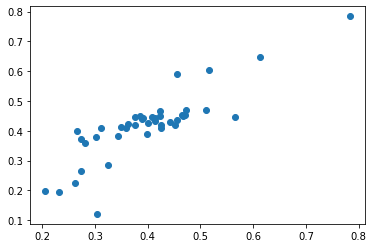

In [145]:
def model_evaluation(y_test, predictions):
    RMSE = np.sqrt(mean_squared_error(y_test, predictions))
    print('RMSE =',RMSE)

    print('R2 =',r2_score(y_test, predictions))
    print('max error=',max(abs(y_test - predictions)))
    plt.figure()
    plt.scatter(x=y_test, y=predictions)

model_evaluation(y_test, predictions)

# Random forest

RMSE = 0.05771612476381883
R2 = 0.7017723904231201
max error= 0.12706333112804574


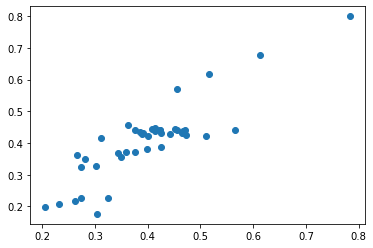

In [161]:
X = train_lm_scaled[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']].values
y = train_lm_scaled['consumption_per_km'].values

# Step 1
# n_estimators=[,,,,,], max_depth=[,,,,,,]

# Curva de aprendizaje
# Variar train size 

# Curva de complejidad
# x cada uno de los parámetros
randF_regr = RandomForestRegressor(n_estimators=25, max_depth=100,
                                   random_state=0,max_features='auto' , criterion='mse', max_samples = 0.1)
randF_regr.fit(X, y)
y_pred = randF_regr.predict(test_scaled[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']].values)
model_evaluation(y_test, y_pred)

In [63]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
print("Initialize Grid Search")
param_grid = { 
    'n_estimators': np.arange(10,90,5),
    'max_depth' : np.arange(10,200,10),
}
# create and fit a regression model, testing each parameter value

 

model = RandomForestRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_params_)

Initialize Grid Search
GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190]),
                         'n_estimators': array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85])})
0.47347800325452416
{'max_depth': 140, 'n_estimators': 30}


In [162]:
dump(randF_regr, open('randomForest_0_12_mean_consumption_maxerr_model.pkl', 'wb'))
dump(scaler, open('scaler.pkl', 'wb'))
dump(scaler_lm, open('scaler_lm.pkl', 'wb'))

# XGBoost

RMSE = 0.06120031608210592
R2 = 0.6646789242992535
max error= 0.15809698425670038


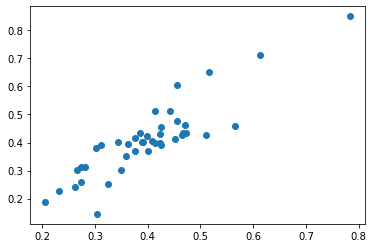

In [176]:


data_dmatrix = xgb.DMatrix(data=X,label=y)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.8,
                max_depth = 100, n_estimators = 100)

# ['mean_max_power_usr', 'mean_soc','nominal_speed', 'slope']
#xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.9,
#                max_depth = 45, n_estimators = 50)

# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.55, learning_rate = 0.425,
#                max_depth = 45, n_estimators = 50)

xg_reg.fit(X, y)

y_pred_xgb = xg_reg.predict(test_scaled[['mean_max_power_usr', 'mean_soc', 'mean_speed', 'slope']].values)
model_evaluation(y_test, y_pred_xgb)

# Save the model
dump(xg_reg, open('xg_reg_model.pickle.dat', 'wb'))


In [1532]:
from sklearn.model_selection import RandomizedSearchCV
print("Initialize Grid Search")
param_distributions = { 
    'n_estimators': np.arange(10,50,15),
    'max_depth' : np.arange(10,40,10),
    'colsample_bytree' : np.arange(0, 1, 0.2),
    'learning_rate' : np.arange(0, 1, 0.2)
}
# create and fit a regression model, testing each parameter value

 

model = xgb.XGBRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_distributions)
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_params_)

Initialize Grid Search
GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_

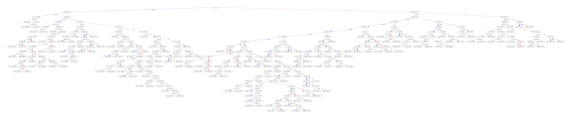

In [849]:
plot = xgb.plot_tree(xg_reg,num_trees=0)
fig = plot.get_figure()
fig.savefig('test2png.png')

In [814]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.214793,0.000212,0.214812,0.000399
1,0.203910,0.001405,0.203861,0.001991
2,0.193265,0.000195,0.193277,0.000462
3,0.183928,0.001673,0.183990,0.001094
4,0.176822,0.002728,0.176960,0.002285
5,0.170569,0.001544,0.170586,0.001561
6,0.166215,0.001496,0.166254,0.001671
7,0.162561,0.001463,0.162611,0.001783
8,0.156895,0.002566,0.157162,0.002380
9,0.154275,0.002578,0.154556,0.002477


# sklearn linear model

RMSE = 0.06704492410544707
R2 = 0.5975746528527992
max error= 0.19266642203536077


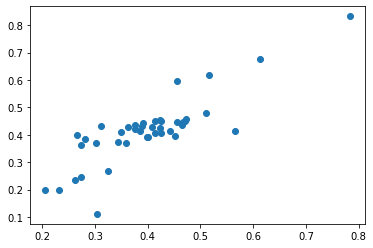

In [38]:
X = train_lm_scaled[['mean_max_power_usr','mean_soc', 'travel_time', 'mass','mass','nominal_speed', 'slope']].values
y = train_lm_scaled['consumption_per_km'].values

from sklearn import linear_model

linear_regr = linear_model.LinearRegression(n_jobs=-1)

linear_regr.fit(X, y)
y_pred_linear = linear_regr.predict(test_scaled[['mean_max_power_usr','mean_soc','travel_time', 'mass', 'mass', 'nominal_speed', 'slope']].values)
model_evaluation(y_test, y_pred_linear)

# Ann

RMSE = 0.06304690747038272
R2 = 0.644138423926055
max error= 0.1680479416757084


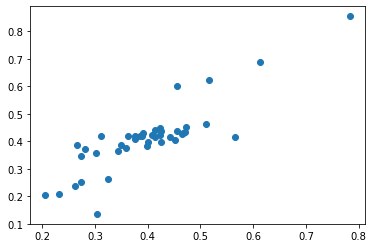

In [39]:
X = train_lm_scaled[['mean_max_power_usr','mean_soc','travel_time','nominal_speed', 'slope']].values
y = train_lm_scaled['consumption_per_km'].values

from sklearn.neural_network import MLPRegressor

ann_regr = MLPRegressor(random_state=1, activation='logistic', alpha=0.001, hidden_layer_sizes= (150,30), max_iter=10500, solver='lbfgs').fit(X, y)

#regr = MLPRegressor(random_state=1, max_iter=500, solver='lbfgs', activation='relu', alpha=0.002, hidden_layer_sizes=(150,)).fit(X, y)
y_ann=ann_regr.predict(test_scaled[['mean_max_power_usr','mean_soc','travel_time', 'nominal_speed', 'slope']].values)
ann_regr.score(test_scaled[['mean_max_power_usr','mean_soc','travel_time','nominal_speed', 'slope']].values, y_test)

model_evaluation(y_test, y_ann)


In [851]:
print("Initialize Grid Search")
param_grid = { 
    'solver':['lbfgs'],
     #arning_rate': ["constant", "invscaling", "adaptive"],
    'hidden_layer_sizes': [(150,100), (150,)],
    'activation': ["logistic", "relu"],
    'max_iter':[10500],
    }


# create and fit a regression model, testing each parameter value


model = MLPRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_params_)

Initialize Grid Search
GridSearchCV(estimator=MLPRegressor(),
             param_grid={'activation': ['logistic', 'relu'],
                         'hidden_layer_sizes': [(150, 100), (150,)],
                         'max_iter': [10500], 'solver': ['lbfgs']})
0.37147874719046303
{'activation': 'logistic', 'hidden_layer_sizes': (150,), 'max_iter': 10500, 'solver': 'lbfgs'}


# Learning curve

max =  -0.06319065865689427
max =  -0.06675274359173433


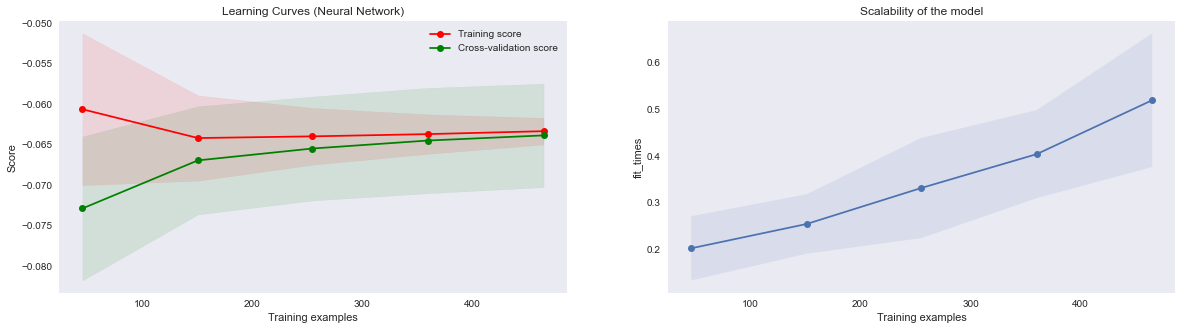

max =  -0.034869619071199516
max =  -0.0673033548590443


<Figure size 576x396 with 0 Axes>

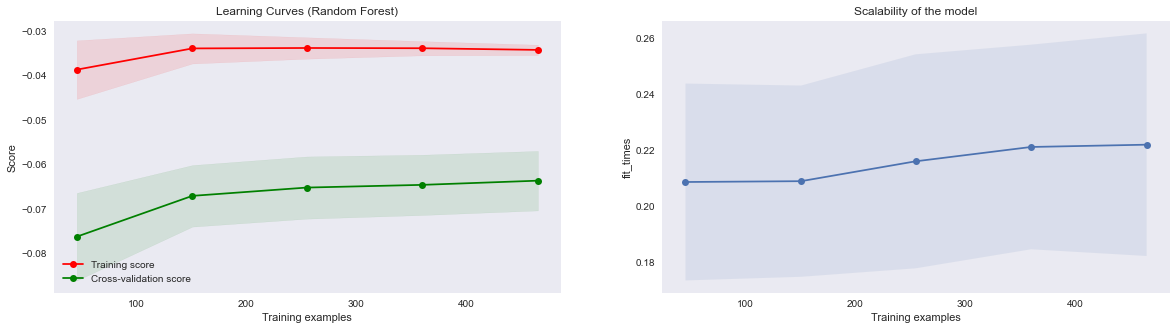

max =  -0.06419651326148074
max =  -0.0672606083116413


<Figure size 576x396 with 0 Axes>

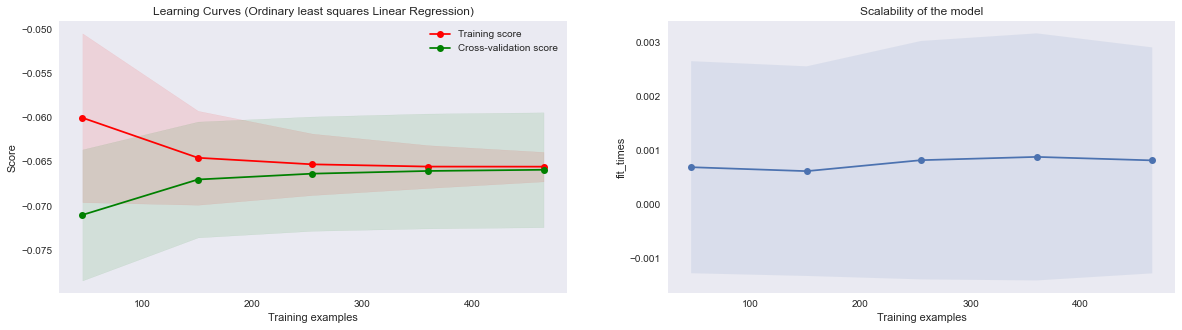

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
 
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    #if ylim is not None:
        #axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring='neg_root_mean_squared_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    print('max = ', np.mean(train_scores))
    print('max = ', np.mean(test_scores))
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    '''
    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, np.sort(test_scores_mean), 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    '''
    return plt


title = "Learning Curves (Neural Network)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = MLPRegressor(random_state=1, activation='logistic', alpha=0.001, hidden_layer_sizes= (150,30),
                         max_iter=10500, solver='lbfgs')
plot_learning_curve(estimator, title, X, y, # ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)
plt.show()

plt.figure()
title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestRegressor(n_estimators=60, max_depth=10,
                                   min_samples_leaf=2,max_features='auto' , criterion='mse', n_jobs=-1)
plot_learning_curve(estimator, title, X, y, # ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

plt.show()

plt.figure()
title = "Learning Curves (Ordinary least squares Linear Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = linear_model.LinearRegression(n_jobs=-1)
plot_learning_curve(estimator, title, X, y,  # ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

plt.show()


In [1153]:
dump(ann_regr, open('ann_regr.pkl', 'wb'))


# Complexity curves

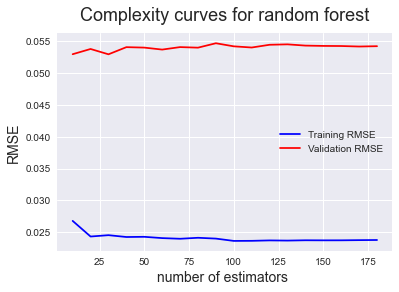

In [51]:
from sklearn.metrics import mean_absolute_error

n_estimators = np.arange(10,190,10)
X_test = test_scaled[['mean_max_power_usr','mean_soc','travel_time','nominal_speed', 'slope']].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for estimators in n_estimators:
    reg = RandomForestRegressor(n_estimators = estimators, max_features='auto', max_depth=50, criterion = 'mse', random_state = 0)
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(n_estimators, train_acc, 'b', label = 'Training RMSE')
plt.plot(n_estimators, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('number of estimators ', fontsize = 14)
plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

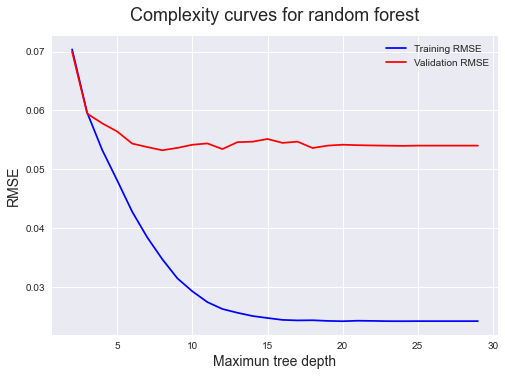

In [54]:
n_estimators = np.arange(2,30,1)
X_test = test_scaled[['mean_max_power_usr','mean_soc','travel_time','nominal_speed', 'slope']].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for estimators in n_estimators:
    reg = RandomForestRegressor(n_estimators = 50, max_features='auto', max_depth=estimators, criterion = 'mse', random_state = 0)
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(n_estimators, train_acc, 'b', label = 'Training RMSE')
plt.plot(n_estimators, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Maximun tree depth', fontsize = 14)
plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

